# Synthetic seismogram

This notebook looks at the convolutional model of a seismic trace.

For a fuller example, see [Bianco, E (2004)](https://github.com/seg/tutorials-2014/blob/master/1406_Make_a_synthetic/how_to_make_synthetic.ipynb) in *The Leading Edge*.

First, the usual preliminaries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load geophysical data

We'll use `lasio` to faciliate loading curves from an LAS file.

In [2]:
from welly import Well
w = Well.from_las('../data/L-30.las')

In [3]:
dt = w.data["DT"]
rhob = w.data["RHOB"]

In [4]:
dt

Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan])

### Exercise

- Convert the logs to SI units

In [5]:
dt = 
rhob = 

SyntaxError: invalid syntax (<ipython-input-5-c63d97b7cff1>, line 1)

In [6]:
dt /= 0.3048
rhob *= 1000

Compute velocity and thus acoustic impedance.

In [7]:
from utils import vp_from_dt, impedance, rc_series

vp = vp_from_dt(dt)
ai = impedance(vp, rhob)
z = dt.basis

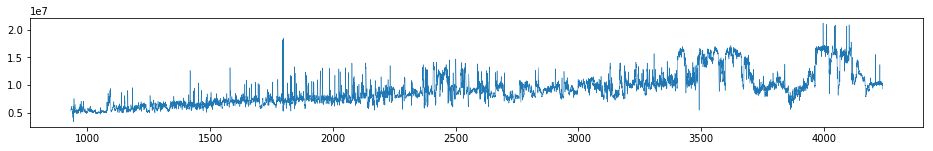

In [8]:
plt.figure(figsize=(16, 2))
plt.plot(z, ai, lw=0.5)
plt.show()

## Depth to time conversion

The logs are in depth, but the seismic is in travel time. So we need to convert the well data to time.

We don't know the seismic time, but we can model it from the DT curve: since DT is 'elapsed time', in microseconds per metre, we can just add up all these time intervals for 'total elapsed time'. Then we can use that to 'look up' the time of a given depth.

We use the step size to scale the DT values to 'seconds per step' (instead of µs/m).

In [9]:
scaled_dt = dt.step * np.nan_to_num(dt) / 1e6  # Convert to seconds per step

### Exercise

- Do the arithmetic to find the timing of the top of the log.

In [10]:
dt.start, w.las.header['Well']['STRT']

(347.47200000000004,
 HeaderItem(mnemonic=STRT, unit=FT, value=1140.0, descr=START DEPTH))

In [11]:
kb = 0.3048 * w.las.header['Well']['KB'].value
gl = 0.3048 * w.las.header['Well']['GL'].value
start = dt.start

v_water = 1480
v_repl = 1800

water_layer =   # Depth of water
repl_layer =    # Thickness of replacement layer

water_twt =     # TWT in water, using water_layer and v_water
repl_twt =      # TWT in replacement layer, using repl_layer and v_repl

print("Water time: {:.3f} ms\nRepl time:  {:.3f} ms".format(water_twt, repl_twt))

SyntaxError: invalid syntax (<ipython-input-11-88914b8d2ab5>, line 8)

You should get

    Water time: 0.186 ms
    Repl time:  0.233 ms

In [12]:
kb = 0.3048 * w.las.header['Well']['KB'].value
gl = 0.3048 * w.las.header['Well']['GL'].value
start = dt.start

v_water = 1480
v_repl = 1800

water_layer = -gl
repl_layer = start + gl

water_twt = 2 * water_layer / v_water
repl_twt = 2 * repl_layer / v_repl

print("Water time: {:.3f} ms\nRepl time:  {:.3f} ms".format(water_twt, repl_twt))

Water time: 0.186 ms
Repl time:  0.233 ms


Now finally we can compute the cumulative time elapsed on the DT log:

In [13]:
dt_time = water_twt + repl_twt + 2*np.cumsum(scaled_dt)

In [14]:
dt_time[-1]

2.8363125071756881

And then use this to convert the logs to a time basis:

In [15]:
delt = 0.004  # Sample interval.
maxt = np.ceil(dt_time[-1])  # Max time that we need; just needs to be longer than the log.

# Make a regular time basis: the seismic time domain.
seis_time = np.arange(0, maxt, delt) 

# Interpolate the AI log onto this basis.
ai_t = np.interp(seis_time, dt_time, ai)

In [16]:
# Let's do the depth 'log' too while we're at it.
z_t = np.interp(seis_time, dt_time, z)

### Exercise

- Make a time-conversion function to get time-converted logs from `delt`, `maxt`, `dt_time`, and a log.
- Make a function to get `dt_time` from `kb`, `gl`, `dt`, `v_water`, `v_repl`.
- Recompute `ai_t` by calling your new functions.
- Plot the DT log in time.

In [17]:
def time_convert(log, dt_time, delt=0.004, maxt=3.0):
    """
    Converts log to the time domain, given dt_time, delt, and maxt.
    
    dt_time is elapsed time regularly sampled in depth. log must
    be sampled on the same depth basis.
    """
    
    # Your code here!
    
    return log_t

In [18]:
def compute_dt_time(dt, kb, gl, v_repl, v_water=1480):
    """
    Compute DT time from the dt log and some other variables.
    
    The DT log must be a welly curve object.
    """

    # Your code here!
    
    return dt_time

In [19]:
def time_convert(log, dt_time, delt=0.004, maxt=None):
    """
    Converts log to the time domain, given dt_time, delt, and maxt.
    
    dt_time is elapsed time regularly sampled in depth. log must
    be sampled on the same depth basis.
    """
    maxt = maxt or np.ceil(dt_time[-1])
    seis_time = np.arange(0, maxt, delt)
    return np.interp(seis_time, dt_time, log)

In [20]:
def compute_dt_time(dt, kb, gl, v_repl, v_water=1480):
    """
    Compute DT time from the dt log and some other variables.
    
    The DT log must be a welly curve object.
    """
    start = dt.start

    v_repl = v_repl or 1800

    water_layer = -gl
    repl_layer = start + gl

    water_twt = 2 * water_layer / v_water
    repl_twt = 2 * repl_layer / v_repl

    scaled_dt = dt.step * np.nan_to_num(dt) / 1e6  # Convert to seconds per step
    dt_time = water_twt + repl_twt + 2*np.cumsum(scaled_dt)
    
    return dt_time

In [21]:
ai_t = time_convert(ai, compute_dt_time(dt, kb, gl, v_repl=1800))

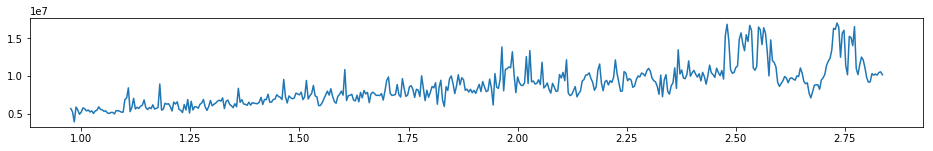

In [22]:
plt.figure(figsize=(16, 2))
plt.plot(seis_time, ai_t)
plt.show()

Now, at last, we can compute the reflection coefficients in time.

In [23]:
from utils import rc_vector

In [24]:
rc = rc_vector(ai_t)
rc[np.isnan(rc)] = 0

Plotting these is a bit more fiddly, because we would like to show them as a sequence of spikes, rather than as a continuous curve, and matplotlib's `axvline` method wants everything in terms of fractions of the plot's dimensions, not as values in the data space.

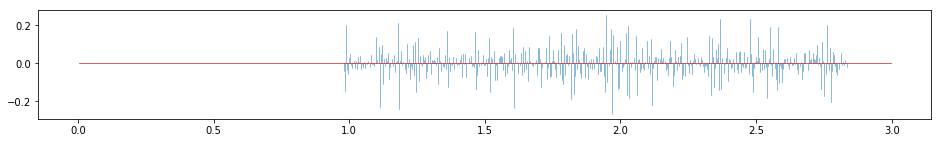

In [25]:
plt.figure(figsize=(16, 2))
pts, stems, base = plt.stem(seis_time[1:], rc)
plt.setp(pts, markersize=0)
plt.setp(stems, lw=0.5)
plt.setp(base, lw=0.75)
plt.show()

## Impulsive wavelet

Convolve with a wavelet.

In [26]:
from bruges.filters import ricker
 
f = 25
w, t = ricker(0.128, 0.004, f, return_t=True)

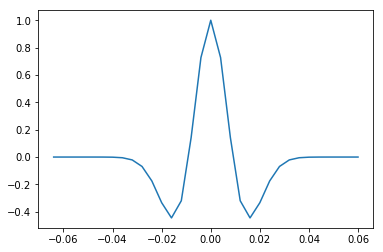

In [27]:
plt.plot(t, w)
plt.show()

In [28]:
syn = np.convolve(rc, w, mode='same')

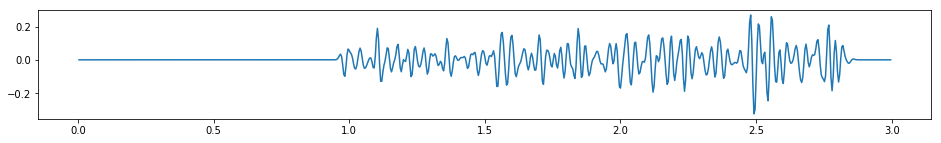

In [29]:
plt.figure(figsize=(16,2))
plt.plot(seis_time[1:], syn)
plt.show()

### Exercise

- Try to plot the RC series with the synthetic.
- You'll need to zoom in a bit to see much, try using a slice of `[300:350]` on all x's and y's.

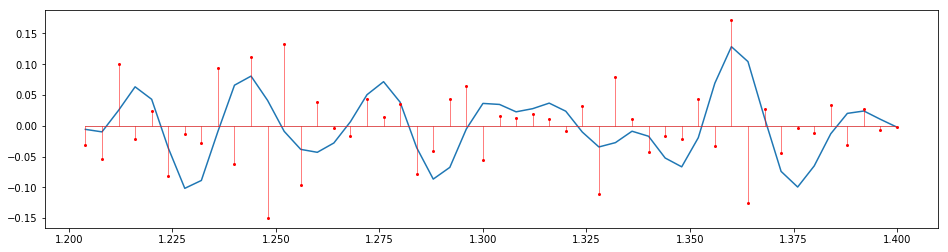

In [30]:
plt.figure(figsize=(16,4))
plt.plot(seis_time[1:][300:350], syn[300:350])

pts, stems, base = plt.stem(seis_time[1:][300:350], rc[300:350])
plt.setp(pts, markersize=2, c='r')
plt.setp(stems, lw=0.5, c='r')
plt.setp(base, lw=0.75)

plt.show()

In [31]:
from ipywidgets import interact

@interact(start=(230,720,10), stop=(250,740,10))
def makeplot(start, stop):
    
    plt.figure(figsize=(16,4))
    plt.plot(seis_time[1:][start:stop], syn[start:stop])

    pts, stems, base = plt.stem(seis_time[1:][start:stop], rc[start:stop])
    plt.setp(pts, markersize=2, c='r')
    plt.setp(stems, lw=0.5, c='r')
    plt.setp(base, lw=0.75)
    
    plt.xlabel('TWT [s]')
    plt.show()
    
    return


A Jupyter Widget

If the widgets don't show up, you might need to do this:

    jupyter nbextension enable --py widgetsnbextension


If we are recording with dynamite or even an airgun, this might be an acceptable model of the seismic. But if we're using Vibroseis, things get more complicated. To get a flavour, try another wavelet in `bruges.filters`, or check out the notebooks:

- [Vibroseis data](../notebooks/Vibroseis_data.ipynb)
- [Wavelets and sweeps](../notebooks/Wavelets_and_sweeps.ipynb)

## Compare with the seismic

In [32]:
seismic = np.loadtxt('../data/Penobscot_xl1155.txt')

In [33]:
syn.shape

(749,)

The synthetic is at trace number 77. We need to make a shifted version of the synthetic to overplot.

In [34]:
tr = 77
gain = 50
s = tr + gain*syn

And we can define semi-real-world cordinates of the seismic data:

In [35]:
extent = (0, 400, 4.0, 0)

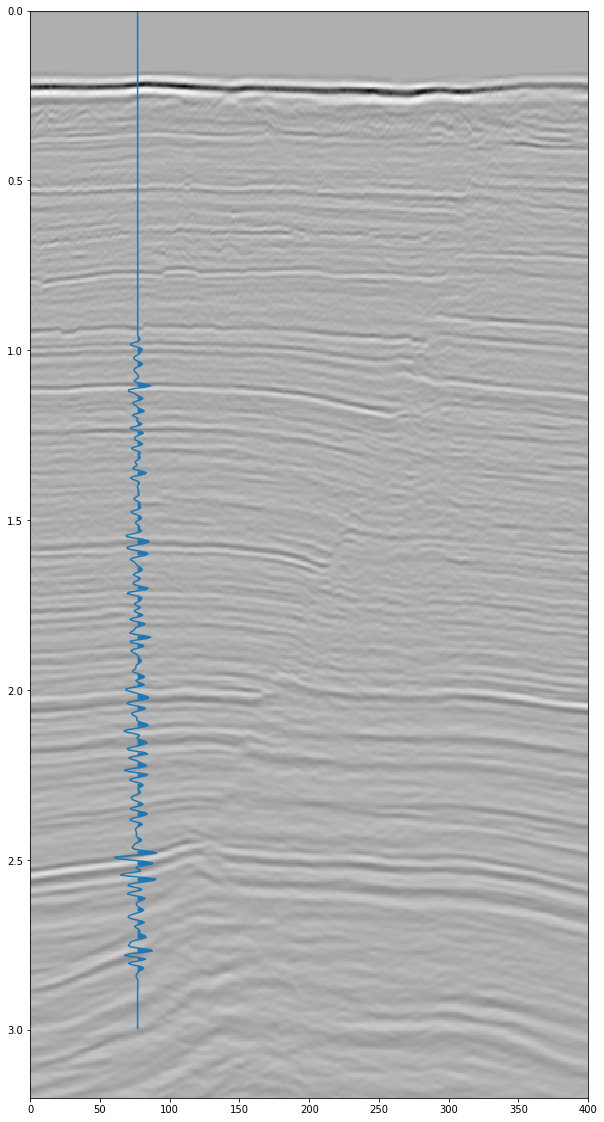

In [36]:
plt.figure(figsize=(10,20))
plt.imshow(seismic.T, cmap='Greys', extent=extent, aspect='auto')
plt.plot(s, seis_time[1:])
plt.fill_betweenx(seis_time[1:], tr, s, where=syn>0, lw=0)
plt.xlim(0, 400)
plt.ylim(3.2, 0)
plt.show()

## Exercise

Load your tops data from `Reading data from files.ipynb` (using `from utils import tops` perhaps), or using the function you made in [`Practice functions`](Practice_functions.ipynb).

- Use the time-converted 'depth', `z_t`, to convert depths to time.
- Plot the tops on the seismic.

In [37]:
from utils import get_tops_from_file

tops = get_tops_from_file('../data/L-30_tops.txt')

In [38]:
top_times = {}
for name, top in tops.items():
    idx = np.argmin(np.abs(z_t - top))
    top_times[name] = seis_time[idx]
    
top_times

{'Abenaki Fm': 2.472,
 'Base O-Marker': 1.992,
 'Dawson Canyon Fm': 1.016,
 'Logan Canyon Fm': 1.1440000000000001,
 'Lower Baccaro': 2.7200000000000002,
 'Lower Missisauga Fm': 2.3719999999999999,
 'Mid Baccaro': 2.508,
 'Pay_Sand_1-Rft': 1.996,
 'Pay_Sand_2': 2.008,
 'Pay_Sand_3': 2.028,
 'Pay_Sand_4': 2.0800000000000001,
 'Sand_5': 2.1120000000000001,
 'Sand_6': 2.1680000000000001,
 'Sand_7': 2.1880000000000002,
 'Td': 2.8399999999999999,
 'Upper Missisauga Fm': 1.8800000000000001,
 'Wyandot Fm': 0.93200000000000005}

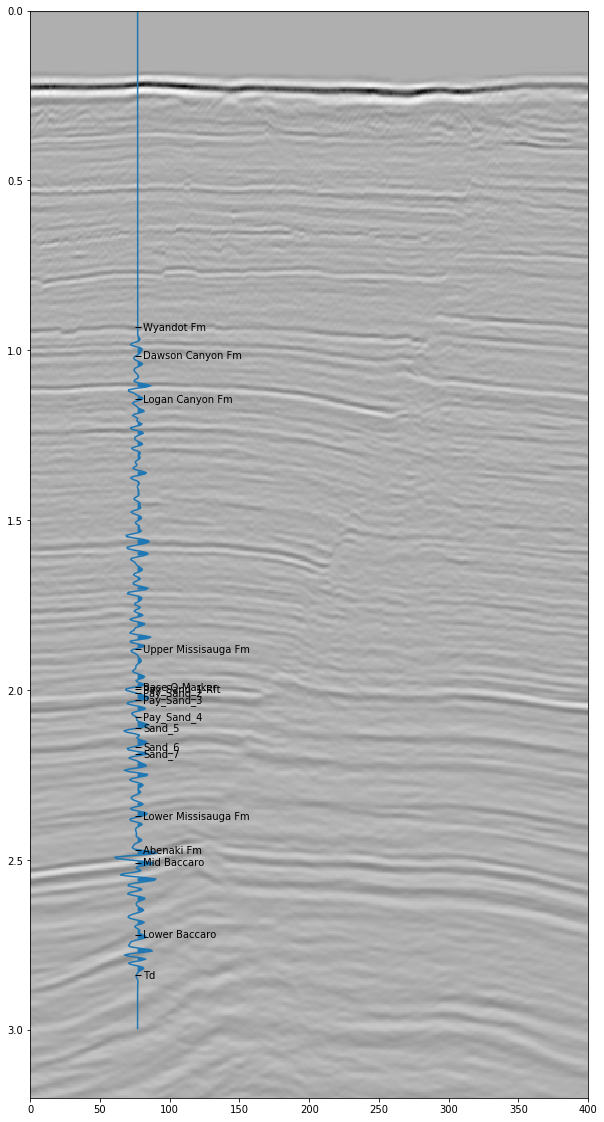

In [39]:
plt.figure(figsize=(10,20))
plt.imshow(seismic.T, cmap='Greys', extent=extent, aspect='auto')
plt.plot(s, seis_time[1:])
plt.fill_betweenx(seis_time[1:], tr, s, where=syn>0, lw=0)
plt.xlim(0, 400)
plt.ylim(3.2, 0)

for name, top in top_times.items():
    plt.text(tr + 4, top, name, va='center')
    plt.plot(tr, top, '_', c='k')

plt.show()

## Exercises

- Make functions for the wavelet creation, synthetic generation, and synthetic plotting steps.
- Make a master function that takes the name of an LAS file, plus any other required info (such as `delt`), and returns a tuple of arrays: a time basis, and the synthetic amplitudes. You could make saving a plot optional.
- Copy this notebook and make an offset synthetic for `R-39.las`, which has a shear-wave DT.

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>